In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import copy
import time

# --- 1. 환경 설정 ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- 2. 데이터셋 로드 및 분리 ---
dataset_dir = "C:/Users/user/Desktop/images/"

# [수정] 원본 ImageFolder 로드는 PIL 이미지를 유지하도록 transform을 최소화
# (normalize_and_resize_img 함수가 PIL 이미지를 입력으로 받기 때문)
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
])
full_dataset = ImageFolder(root=dataset_dir, transform=base_transform)

ds_info = {
    "num_classes": len(full_dataset.classes),
    "class_names": full_dataset.classes
}

total_size = len(full_dataset)
train_size = int(0.583 * total_size)
test_size = total_size - train_size
ds_train, ds_test = random_split(full_dataset, [train_size, test_size])

print(f"Total classes: {ds_info['num_classes']} | Train size: {len(ds_train)} | Test size: {len(ds_test)}")

# --- 3. 데이터 로더 헬퍼 함수 정의 ---

# 이미지 정규화 및 크기 조정
def normalize_and_resize_img(image, label):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform(image), label

# 기본 데이터 증강
def augment(image, label):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2),
    ])
    return transform(image), label

# 원-핫 인코딩
def onehot(label_tensor, num_classes):
    if not isinstance(label_tensor, torch.Tensor):
        label_tensor = torch.tensor(label_tensor)
    return torch.nn.functional.one_hot(label_tensor.long(), num_classes=num_classes).float()

# [수정] 데이터셋 적용 함수 (원본의 버그 수정)
# 1. 'onehot'은 훈련 루프에서 처리하도록 제거
# 2. 'with_cutmix' 플래그 제거
def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False):
    
    # 1. (PIL, label) -> (Aug_PIL, label)
    if not is_test and with_aug:
        processed_dataset = [augment(img, lbl) for img, lbl in tqdm(dataset, desc="Applying Basic Aug")]
    else:
        processed_dataset = [(img, lbl) for img, lbl in dataset]

    # 2. (Aug_PIL, label) -> (Norm_Tensor, label)
    final_dataset = []
    for img, lbl in tqdm(processed_dataset, desc="Applying Norm/ToTensor"):
        norm_img, _ = normalize_and_resize_img(img, lbl)
        final_dataset.append((norm_img, lbl)) # 라벨은 '인덱스'로 유지

    dataloader = DataLoader(final_dataset, 
                            batch_size=batch_size, 
                            shuffle=not is_test, 
                            num_workers=2, 
                            pin_memory=True)
    return dataloader

# --- 4. CutMix / MixUp 헬퍼 함수 정의 (원본 코드 셀 19~25) ---

# CutMix
def get_clip_box(image_a, image_b):
    image_size_x, image_size_y = image_a.shape[2], image_a.shape[1]
    x = torch.randint(0, image_size_x, (1,)).item()
    y = torch.randint(0, image_size_y, (1,)).item()
    width = max(1, int(image_size_x * torch.sqrt(1 - torch.rand(1)).item()))
    height = max(1, int(image_size_y * torch.sqrt(1 - torch.rand(1)).item()))
    x_min = max(0, x - width // 2)
    y_min = max(0, y - height // 2)
    x_max = min(image_size_x, x + width // 2 + 1)
    y_max = min(image_size_y, y + height // 2 + 1)
    return x_min, y_min, x_max, y_max

def mix_2_labels(label_a_onehot, label_b_onehot, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x, image_size_y = 224, 224 # (가정)
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = mixed_area / total_area
    mixed_label = (1 - ratio) * label_a_onehot + ratio * label_b_onehot
    return mixed_label

def cutmix(images_batch, labels_batch_onehot, num_classes=120):
    batch_size = images_batch.shape[0]
    mixed_imgs = images_batch.clone()
    mixed_labels = labels_batch_onehot.clone()

    for i in range(batch_size):
        j = torch.randint(0, batch_size, (1,)).item()
        x_min, y_min, x_max, y_max = get_clip_box(images_batch[i], images_batch[j])
        
        # Mix Images
        mixed_imgs[i, :, y_min:y_max, x_min:x_max] = images_batch[j, :, y_min:y_max, x_min:x_max]
        # Mix Labels
        mixed_labels[i] = mix_2_labels(labels_batch_onehot[i], labels_batch_onehot[j], x_min, y_min, x_max, y_max, num_classes)
        
    return mixed_imgs, mixed_labels

# MixUp
def mixup(images_batch, labels_batch_onehot, num_classes=120):
    batch_size = images_batch.shape[0]
    mixed_imgs = torch.zeros_like(images_batch)
    mixed_labels = torch.zeros_like(labels_batch_onehot)
    
    for i in range(batch_size):
        j = torch.randint(0, batch_size, (1,)).item()
        ratio = torch.rand(1).item()
        
        mixed_imgs[i] = (1 - ratio) * images_batch[i] + ratio * images_batch[j]
        mixed_labels[i] = (1 - ratio) * labels_batch_onehot[i] + ratio * labels_batch_onehot[j]
        
    return mixed_imgs, mixed_labels


# --- 5. 모델 정의 ---
def build_resnet50(num_classes):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# --- 6. [중요] 통합 훈련 함수 정의 ---
# --- 6. [중요] 통합 훈련 함수 정의 ---
def train_model(model, train_loader, test_loader, epochs, learning_rate, augmentation_mode='none'):
    model.to(device)
    # [수정] CrossEntropyLoss는 soft-label(확률)과 index-label(정수) 모두 처리 가능
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    num_classes = ds_info['num_classes']
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    print(f"\n--- Training started (Mode: {augmentation_mode}) ---")
    start_time = time.time()
    
    for epoch in range(epochs):
        # --- 훈련 ---
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for images, labels_idx in train_bar:
            images = images.to(device)
            labels_idx = labels_idx.to(device) # [6, 2, 10, ...]
            
            # Augmentation 적용
            if augmentation_mode in ['mixup', 'cutmix']:
                # 1. 라벨을 원-핫으로 변환
                labels_onehot = onehot(labels_idx, num_classes).to(device)
                
                # 2. MixUp 또는 CutMix 적용 (Soft-Label 생성)
                if augmentation_mode == 'mixup':
                    images, labels_out = mixup(images, labels_onehot, num_classes)
                else: # 'cutmix'
                    images, labels_out = cutmix(images, labels_onehot, num_classes)
            
            else: # 'none' 또는 'basic'
                labels_out = labels_idx # [6, 2, 10, ...]

            # 순전파
            optimizer.zero_grad()
            outputs = model(images)
            
            # 손실 계산
            loss = criterion(outputs, labels_out)
            loss.backward()
            optimizer.step()

            # 통계 (정확도는 항상 argmax로 비교)
            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            train_total += labels_idx.size(0) # 원본 인덱스 라벨(labels_idx)
            train_correct += predicted.eq(labels_idx).sum().item() # [주의] 정확도는 항상 원본 인덱스 라벨(labels_idx)과 비교
            
            train_bar.set_postfix(loss=(train_loss/train_total), acc=(100.*train_correct/train_total))

        epoch_train_loss = train_loss / train_total
        epoch_train_acc = 100. * train_correct / train_total
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # --- 검증 ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        
        with torch.no_grad():
            for images, labels_idx in test_loader:
                images, labels_idx = images.to(device), labels_idx.to(device)
                outputs = model(images)
                
                loss = criterion(outputs, labels_idx) # 검증은 항상 인덱스 라벨 사용
                
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                
                # [!] 여기가 수정된 부분입니다.
                val_total += labels_idx.size(0) 
                
                val_correct += predicted.eq(labels_idx).sum().item()

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = 100. * val_correct / val_total
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%")
        
    end_time = time.time()
    print(f"--- Training finished (Mode: {augmentation_mode}) | Total Time: {end_time - start_time:.2f}s ---")
    return history

Using device: cuda
Total classes: 120 | Train size: 11998 | Test size: 8582


In [10]:
# --- 1. 훈련 파라미터 설정 ---
EPOCH = 50 # (원본 코드와 동일. 더 나은 비교를 위해 10~20 추천)
LR = 0.001
BATCH_SIZE = 32

# --- 2. 4가지 모델 인스턴스 생성 ---
num_classes = ds_info['num_classes']
model_no_aug = build_resnet50(num_classes)
model_aug = build_resnet50(num_classes)
model_mixup = build_resnet50(num_classes)
model_cutmix = build_resnet50(num_classes)

# --- 3. 데이터 로더 생성 ---
print("Creating DataLoaders...")
# (1) 증강 미적용 훈련 로더
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False, batch_size=BATCH_SIZE)
# (2) 기본 증강 적용 훈련 로더 (MixUp, CutMix가 이것을 공통으로 사용)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True, batch_size=BATCH_SIZE)
# (3) 테스트 로더 (공통)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)
print("DataLoaders ready.")

# --- 4. 훈련 실행 ---
histories = {}

# 1. No Augmentation
history_no_aug = train_model(model_no_aug, ds_train_no_aug, ds_test, EPOCH, LR, augmentation_mode='none')
histories['No Aug'] = history_no_aug

# 2. Basic Augmentation
history_aug = train_model(model_aug, ds_train_aug, ds_test, EPOCH, LR, augmentation_mode='basic')
histories['Basic Aug'] = history_aug

# 3. MixUp (기본 증강 로더 사용)
history_mixup = train_model(model_mixup, ds_train_aug, ds_test, EPOCH, LR, augmentation_mode='mixup')
histories['MixUp'] = history_mixup

# 4. CutMix (기본 증강 로더 사용)
history_cutmix = train_model(model_cutmix, ds_train_aug, ds_test, EPOCH, LR, augmentation_mode='cutmix')
histories['CutMix'] = history_cutmix

print("\n--- All 4 training sessions complete. ---")

Creating DataLoaders...


Applying Norm/ToTensor: 100%|██████████| 8582/8582 [00:05<00:00, 1601.80it/s]


DataLoaders ready.

--- Training started (Mode: none) ---


Epoch 1/50 [Train]: 100%|██████████| 375/375 [00:22<00:00, 16.56it/s, acc=7.05, loss=4.63]


Epoch 1/50 | Train Loss: 4.6321 | Train Acc: 7.05% | Val Loss: 4.3724 | Val Acc: 20.69%


Epoch 2/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.36it/s, acc=31.1, loss=4.14]


Epoch 2/50 | Train Loss: 4.1443 | Train Acc: 31.09% | Val Loss: 3.8082 | Val Acc: 42.81%


Epoch 3/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.40it/s, acc=47.2, loss=3.59]


Epoch 3/50 | Train Loss: 3.5901 | Train Acc: 47.22% | Val Loss: 3.1883 | Val Acc: 53.54%


Epoch 4/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.36it/s, acc=56.9, loss=3.05]


Epoch 4/50 | Train Loss: 3.0497 | Train Acc: 56.89% | Val Loss: 2.6616 | Val Acc: 61.27%


Epoch 5/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.26it/s, acc=64.4, loss=2.58]


Epoch 5/50 | Train Loss: 2.5776 | Train Acc: 64.44% | Val Loss: 2.2190 | Val Acc: 67.82%


Epoch 6/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.45it/s, acc=69.2, loss=2.19]


Epoch 6/50 | Train Loss: 2.1916 | Train Acc: 69.19% | Val Loss: 1.8540 | Val Acc: 72.08%


Epoch 7/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.46it/s, acc=73.7, loss=1.88]


Epoch 7/50 | Train Loss: 1.8828 | Train Acc: 73.72% | Val Loss: 1.5681 | Val Acc: 75.18%


Epoch 8/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.45it/s, acc=76.5, loss=1.64]


Epoch 8/50 | Train Loss: 1.6358 | Train Acc: 76.50% | Val Loss: 1.3580 | Val Acc: 77.48%


Epoch 9/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.43it/s, acc=78.9, loss=1.44]


Epoch 9/50 | Train Loss: 1.4396 | Train Acc: 78.85% | Val Loss: 1.2052 | Val Acc: 78.89%


Epoch 10/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.45it/s, acc=80.6, loss=1.28]


Epoch 10/50 | Train Loss: 1.2847 | Train Acc: 80.62% | Val Loss: 1.0959 | Val Acc: 79.31%


Epoch 11/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.35it/s, acc=81.4, loss=1.16]


Epoch 11/50 | Train Loss: 1.1622 | Train Acc: 81.37% | Val Loss: 0.9936 | Val Acc: 80.39%


Epoch 12/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.30it/s, acc=82.9, loss=1.05]


Epoch 12/50 | Train Loss: 1.0521 | Train Acc: 82.91% | Val Loss: 0.9311 | Val Acc: 81.12%


Epoch 13/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.46it/s, acc=83.5, loss=0.97] 


Epoch 13/50 | Train Loss: 0.9697 | Train Acc: 83.47% | Val Loss: 0.8706 | Val Acc: 81.67%


Epoch 14/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.25it/s, acc=84.8, loss=0.899]


Epoch 14/50 | Train Loss: 0.8987 | Train Acc: 84.82% | Val Loss: 0.8189 | Val Acc: 82.08%


Epoch 15/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.29it/s, acc=85.6, loss=0.828]


Epoch 15/50 | Train Loss: 0.8277 | Train Acc: 85.58% | Val Loss: 0.7818 | Val Acc: 82.18%


Epoch 16/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.35it/s, acc=86.4, loss=0.764]


Epoch 16/50 | Train Loss: 0.7644 | Train Acc: 86.42% | Val Loss: 0.7538 | Val Acc: 82.54%


Epoch 17/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.36it/s, acc=87.1, loss=0.718]


Epoch 17/50 | Train Loss: 0.7180 | Train Acc: 87.08% | Val Loss: 0.7279 | Val Acc: 82.73%


Epoch 18/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.25it/s, acc=87.6, loss=0.673]


Epoch 18/50 | Train Loss: 0.6735 | Train Acc: 87.61% | Val Loss: 0.6961 | Val Acc: 82.91%


Epoch 19/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.26it/s, acc=88.7, loss=0.634]


Epoch 19/50 | Train Loss: 0.6343 | Train Acc: 88.71% | Val Loss: 0.6816 | Val Acc: 82.87%


Epoch 20/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.38it/s, acc=89.3, loss=0.596]


Epoch 20/50 | Train Loss: 0.5964 | Train Acc: 89.31% | Val Loss: 0.6558 | Val Acc: 83.33%


Epoch 21/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.25it/s, acc=90, loss=0.561]  


Epoch 21/50 | Train Loss: 0.5614 | Train Acc: 89.97% | Val Loss: 0.6432 | Val Acc: 83.19%


Epoch 22/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.32it/s, acc=90.3, loss=0.534]


Epoch 22/50 | Train Loss: 0.5339 | Train Acc: 90.32% | Val Loss: 0.6353 | Val Acc: 83.42%


Epoch 23/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.33it/s, acc=91.1, loss=0.5]  


Epoch 23/50 | Train Loss: 0.5003 | Train Acc: 91.07% | Val Loss: 0.6230 | Val Acc: 83.75%


Epoch 24/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.23it/s, acc=91.5, loss=0.475]


Epoch 24/50 | Train Loss: 0.4749 | Train Acc: 91.49% | Val Loss: 0.6084 | Val Acc: 83.63%


Epoch 25/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.48it/s, acc=91.9, loss=0.449]


Epoch 25/50 | Train Loss: 0.4486 | Train Acc: 91.87% | Val Loss: 0.6057 | Val Acc: 83.52%


Epoch 26/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.53it/s, acc=92.8, loss=0.421]


Epoch 26/50 | Train Loss: 0.4213 | Train Acc: 92.80% | Val Loss: 0.5944 | Val Acc: 83.75%


Epoch 27/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.47it/s, acc=93, loss=0.402]  


Epoch 27/50 | Train Loss: 0.4020 | Train Acc: 92.97% | Val Loss: 0.5846 | Val Acc: 83.62%


Epoch 28/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.36it/s, acc=93.6, loss=0.385]


Epoch 28/50 | Train Loss: 0.3846 | Train Acc: 93.63% | Val Loss: 0.5832 | Val Acc: 83.57%


Epoch 29/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.36it/s, acc=93.9, loss=0.362]


Epoch 29/50 | Train Loss: 0.3615 | Train Acc: 93.87% | Val Loss: 0.5820 | Val Acc: 83.61%


Epoch 30/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.48it/s, acc=94, loss=0.345]  


Epoch 30/50 | Train Loss: 0.3447 | Train Acc: 94.03% | Val Loss: 0.5703 | Val Acc: 83.78%


Epoch 31/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.36it/s, acc=94.6, loss=0.328]


Epoch 31/50 | Train Loss: 0.3282 | Train Acc: 94.65% | Val Loss: 0.5657 | Val Acc: 83.87%


Epoch 32/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.25it/s, acc=94.9, loss=0.312]


Epoch 32/50 | Train Loss: 0.3124 | Train Acc: 94.92% | Val Loss: 0.5646 | Val Acc: 83.63%


Epoch 33/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.27it/s, acc=95.4, loss=0.302]


Epoch 33/50 | Train Loss: 0.3020 | Train Acc: 95.40% | Val Loss: 0.5643 | Val Acc: 83.84%


Epoch 34/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.33it/s, acc=95.7, loss=0.28] 


Epoch 34/50 | Train Loss: 0.2801 | Train Acc: 95.72% | Val Loss: 0.5620 | Val Acc: 83.62%


Epoch 35/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.25it/s, acc=95.7, loss=0.271]


Epoch 35/50 | Train Loss: 0.2714 | Train Acc: 95.66% | Val Loss: 0.5566 | Val Acc: 83.68%


Epoch 36/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.33it/s, acc=96.1, loss=0.258]


Epoch 36/50 | Train Loss: 0.2583 | Train Acc: 96.12% | Val Loss: 0.5606 | Val Acc: 83.65%


Epoch 37/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.24it/s, acc=96.4, loss=0.244]


Epoch 37/50 | Train Loss: 0.2436 | Train Acc: 96.42% | Val Loss: 0.5586 | Val Acc: 83.68%


Epoch 38/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.26it/s, acc=96.5, loss=0.234]


Epoch 38/50 | Train Loss: 0.2340 | Train Acc: 96.55% | Val Loss: 0.5539 | Val Acc: 83.76%


Epoch 39/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.48it/s, acc=97, loss=0.224]  


Epoch 39/50 | Train Loss: 0.2235 | Train Acc: 97.04% | Val Loss: 0.5528 | Val Acc: 83.62%


Epoch 40/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.58it/s, acc=96.9, loss=0.212]


Epoch 40/50 | Train Loss: 0.2124 | Train Acc: 96.93% | Val Loss: 0.5518 | Val Acc: 83.41%


Epoch 41/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.53it/s, acc=97.3, loss=0.205]


Epoch 41/50 | Train Loss: 0.2050 | Train Acc: 97.28% | Val Loss: 0.5547 | Val Acc: 83.59%


Epoch 42/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.48it/s, acc=97.6, loss=0.194]


Epoch 42/50 | Train Loss: 0.1935 | Train Acc: 97.59% | Val Loss: 0.5540 | Val Acc: 83.48%


Epoch 43/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.57it/s, acc=97.5, loss=0.187]


Epoch 43/50 | Train Loss: 0.1870 | Train Acc: 97.51% | Val Loss: 0.5549 | Val Acc: 83.52%


Epoch 44/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.51it/s, acc=97.7, loss=0.18] 


Epoch 44/50 | Train Loss: 0.1799 | Train Acc: 97.70% | Val Loss: 0.5535 | Val Acc: 83.57%


Epoch 45/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.47it/s, acc=98, loss=0.171]  


Epoch 45/50 | Train Loss: 0.1712 | Train Acc: 98.01% | Val Loss: 0.5538 | Val Acc: 83.48%


Epoch 46/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.42it/s, acc=98.2, loss=0.163]


Epoch 46/50 | Train Loss: 0.1633 | Train Acc: 98.17% | Val Loss: 0.5513 | Val Acc: 83.68%


Epoch 47/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.48it/s, acc=98.2, loss=0.16] 


Epoch 47/50 | Train Loss: 0.1600 | Train Acc: 98.19% | Val Loss: 0.5539 | Val Acc: 83.50%


Epoch 48/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.38it/s, acc=98.3, loss=0.151]


Epoch 48/50 | Train Loss: 0.1506 | Train Acc: 98.27% | Val Loss: 0.5541 | Val Acc: 83.29%


Epoch 49/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.47it/s, acc=98.5, loss=0.142]


Epoch 49/50 | Train Loss: 0.1424 | Train Acc: 98.49% | Val Loss: 0.5598 | Val Acc: 83.17%


Epoch 50/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.28it/s, acc=98.6, loss=0.141]


Epoch 50/50 | Train Loss: 0.1405 | Train Acc: 98.58% | Val Loss: 0.5554 | Val Acc: 83.27%
--- Training finished (Mode: none) | Total Time: 1317.17s ---

--- Training started (Mode: basic) ---


Epoch 1/50 [Train]: 100%|██████████| 375/375 [00:24<00:00, 15.47it/s, acc=8.27, loss=4.6] 


Epoch 1/50 | Train Loss: 4.5967 | Train Acc: 8.27% | Val Loss: 4.3391 | Val Acc: 21.71%


Epoch 2/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.43it/s, acc=31.5, loss=4.1] 


Epoch 2/50 | Train Loss: 4.1035 | Train Acc: 31.54% | Val Loss: 3.7612 | Val Acc: 42.45%


Epoch 3/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.51it/s, acc=48.1, loss=3.55]


Epoch 3/50 | Train Loss: 3.5513 | Train Acc: 48.10% | Val Loss: 3.1736 | Val Acc: 55.64%


Epoch 4/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.33it/s, acc=58, loss=3.02]  


Epoch 4/50 | Train Loss: 3.0223 | Train Acc: 57.99% | Val Loss: 2.6027 | Val Acc: 63.59%


Epoch 5/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.49it/s, acc=65.1, loss=2.55]


Epoch 5/50 | Train Loss: 2.5540 | Train Acc: 65.10% | Val Loss: 2.1988 | Val Acc: 69.09%


Epoch 6/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.30it/s, acc=70.4, loss=2.17]


Epoch 6/50 | Train Loss: 2.1728 | Train Acc: 70.40% | Val Loss: 1.8361 | Val Acc: 72.78%


Epoch 7/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.37it/s, acc=74.1, loss=1.87]


Epoch 7/50 | Train Loss: 1.8686 | Train Acc: 74.11% | Val Loss: 1.5547 | Val Acc: 75.83%


Epoch 8/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.53it/s, acc=77.3, loss=1.62]


Epoch 8/50 | Train Loss: 1.6228 | Train Acc: 77.27% | Val Loss: 1.3618 | Val Acc: 77.39%


Epoch 9/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.53it/s, acc=78.8, loss=1.43]


Epoch 9/50 | Train Loss: 1.4333 | Train Acc: 78.81% | Val Loss: 1.2052 | Val Acc: 78.91%


Epoch 10/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.50it/s, acc=80, loss=1.28]  


Epoch 10/50 | Train Loss: 1.2831 | Train Acc: 80.02% | Val Loss: 1.0894 | Val Acc: 79.55%


Epoch 11/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.63it/s, acc=81.7, loss=1.15]


Epoch 11/50 | Train Loss: 1.1547 | Train Acc: 81.73% | Val Loss: 1.0008 | Val Acc: 80.42%


Epoch 12/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.50it/s, acc=83.3, loss=1.05]


Epoch 12/50 | Train Loss: 1.0479 | Train Acc: 83.31% | Val Loss: 0.9257 | Val Acc: 81.04%


Epoch 13/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.30it/s, acc=83.4, loss=0.974]


Epoch 13/50 | Train Loss: 0.9741 | Train Acc: 83.40% | Val Loss: 0.8603 | Val Acc: 81.53%


Epoch 14/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.32it/s, acc=84.7, loss=0.896]


Epoch 14/50 | Train Loss: 0.8960 | Train Acc: 84.72% | Val Loss: 0.8156 | Val Acc: 82.11%


Epoch 15/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.67it/s, acc=85.4, loss=0.833]


Epoch 15/50 | Train Loss: 0.8333 | Train Acc: 85.41% | Val Loss: 0.7729 | Val Acc: 82.37%


Epoch 16/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.53it/s, acc=86.3, loss=0.773]


Epoch 16/50 | Train Loss: 0.7731 | Train Acc: 86.34% | Val Loss: 0.7485 | Val Acc: 82.53%


Epoch 17/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.52it/s, acc=87.5, loss=0.715]


Epoch 17/50 | Train Loss: 0.7155 | Train Acc: 87.54% | Val Loss: 0.7220 | Val Acc: 82.79%


Epoch 18/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.74it/s, acc=88.3, loss=0.678]


Epoch 18/50 | Train Loss: 0.6776 | Train Acc: 88.26% | Val Loss: 0.6929 | Val Acc: 83.01%


Epoch 19/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.41it/s, acc=88.6, loss=0.632]


Epoch 19/50 | Train Loss: 0.6315 | Train Acc: 88.61% | Val Loss: 0.6714 | Val Acc: 83.16%


Epoch 20/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.54it/s, acc=89.4, loss=0.598]


Epoch 20/50 | Train Loss: 0.5980 | Train Acc: 89.45% | Val Loss: 0.6565 | Val Acc: 83.22%


Epoch 21/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.48it/s, acc=89.4, loss=0.566]


Epoch 21/50 | Train Loss: 0.5659 | Train Acc: 89.39% | Val Loss: 0.6429 | Val Acc: 83.58%


Epoch 22/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.43it/s, acc=90.5, loss=0.532]


Epoch 22/50 | Train Loss: 0.5323 | Train Acc: 90.47% | Val Loss: 0.6274 | Val Acc: 83.78%


Epoch 23/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.37it/s, acc=91.3, loss=0.5]  


Epoch 23/50 | Train Loss: 0.4996 | Train Acc: 91.31% | Val Loss: 0.6170 | Val Acc: 83.93%


Epoch 24/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.51it/s, acc=91.3, loss=0.477]


Epoch 24/50 | Train Loss: 0.4772 | Train Acc: 91.31% | Val Loss: 0.6092 | Val Acc: 84.02%


Epoch 25/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.41it/s, acc=91.6, loss=0.452]


Epoch 25/50 | Train Loss: 0.4522 | Train Acc: 91.60% | Val Loss: 0.6009 | Val Acc: 83.73%


Epoch 26/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.42it/s, acc=92.5, loss=0.425]


Epoch 26/50 | Train Loss: 0.4248 | Train Acc: 92.50% | Val Loss: 0.5949 | Val Acc: 83.61%


Epoch 27/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.28it/s, acc=93, loss=0.405]  


Epoch 27/50 | Train Loss: 0.4047 | Train Acc: 93.05% | Val Loss: 0.5839 | Val Acc: 83.87%


Epoch 28/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.31it/s, acc=93.7, loss=0.38] 


Epoch 28/50 | Train Loss: 0.3804 | Train Acc: 93.67% | Val Loss: 0.5772 | Val Acc: 83.84%


Epoch 29/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.38it/s, acc=94, loss=0.362]  


Epoch 29/50 | Train Loss: 0.3623 | Train Acc: 94.01% | Val Loss: 0.5747 | Val Acc: 83.91%


Epoch 30/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.41it/s, acc=94.3, loss=0.344]


Epoch 30/50 | Train Loss: 0.3438 | Train Acc: 94.31% | Val Loss: 0.5694 | Val Acc: 84.00%


Epoch 31/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.53it/s, acc=94.6, loss=0.327]


Epoch 31/50 | Train Loss: 0.3274 | Train Acc: 94.59% | Val Loss: 0.5687 | Val Acc: 83.91%


Epoch 32/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.52it/s, acc=95, loss=0.315]  


Epoch 32/50 | Train Loss: 0.3154 | Train Acc: 95.02% | Val Loss: 0.5595 | Val Acc: 83.91%


Epoch 33/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.35it/s, acc=95.4, loss=0.294]


Epoch 33/50 | Train Loss: 0.2944 | Train Acc: 95.42% | Val Loss: 0.5619 | Val Acc: 84.08%


Epoch 34/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.62it/s, acc=95.5, loss=0.281]


Epoch 34/50 | Train Loss: 0.2809 | Train Acc: 95.53% | Val Loss: 0.5589 | Val Acc: 83.92%


Epoch 35/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.62it/s, acc=95.8, loss=0.268]


Epoch 35/50 | Train Loss: 0.2678 | Train Acc: 95.83% | Val Loss: 0.5605 | Val Acc: 84.01%


Epoch 36/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.61it/s, acc=96.2, loss=0.258]


Epoch 36/50 | Train Loss: 0.2583 | Train Acc: 96.22% | Val Loss: 0.5509 | Val Acc: 84.02%


Epoch 37/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.54it/s, acc=96.5, loss=0.247]


Epoch 37/50 | Train Loss: 0.2466 | Train Acc: 96.52% | Val Loss: 0.5541 | Val Acc: 83.75%


Epoch 38/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.53it/s, acc=96.7, loss=0.235]


Epoch 38/50 | Train Loss: 0.2355 | Train Acc: 96.67% | Val Loss: 0.5524 | Val Acc: 83.90%


Epoch 39/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.60it/s, acc=96.9, loss=0.222]


Epoch 39/50 | Train Loss: 0.2224 | Train Acc: 96.86% | Val Loss: 0.5497 | Val Acc: 83.91%


Epoch 40/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.35it/s, acc=96.9, loss=0.213]


Epoch 40/50 | Train Loss: 0.2133 | Train Acc: 96.87% | Val Loss: 0.5481 | Val Acc: 83.95%


Epoch 41/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.57it/s, acc=97.4, loss=0.206]


Epoch 41/50 | Train Loss: 0.2060 | Train Acc: 97.42% | Val Loss: 0.5513 | Val Acc: 83.93%


Epoch 42/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.55it/s, acc=97.5, loss=0.193]


Epoch 42/50 | Train Loss: 0.1934 | Train Acc: 97.47% | Val Loss: 0.5434 | Val Acc: 83.90%


Epoch 43/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.57it/s, acc=97.5, loss=0.187]


Epoch 43/50 | Train Loss: 0.1874 | Train Acc: 97.52% | Val Loss: 0.5486 | Val Acc: 83.86%


Epoch 44/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.50it/s, acc=97.9, loss=0.181]


Epoch 44/50 | Train Loss: 0.1806 | Train Acc: 97.89% | Val Loss: 0.5443 | Val Acc: 84.02%


Epoch 45/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.55it/s, acc=97.8, loss=0.172]


Epoch 45/50 | Train Loss: 0.1716 | Train Acc: 97.83% | Val Loss: 0.5456 | Val Acc: 83.95%


Epoch 46/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.62it/s, acc=98, loss=0.167]  


Epoch 46/50 | Train Loss: 0.1669 | Train Acc: 98.03% | Val Loss: 0.5455 | Val Acc: 83.80%


Epoch 47/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.62it/s, acc=98.4, loss=0.158]


Epoch 47/50 | Train Loss: 0.1581 | Train Acc: 98.38% | Val Loss: 0.5422 | Val Acc: 83.88%


Epoch 48/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.69it/s, acc=98.4, loss=0.151]


Epoch 48/50 | Train Loss: 0.1505 | Train Acc: 98.43% | Val Loss: 0.5490 | Val Acc: 83.69%


Epoch 49/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.60it/s, acc=98.4, loss=0.146]


Epoch 49/50 | Train Loss: 0.1461 | Train Acc: 98.37% | Val Loss: 0.5503 | Val Acc: 83.84%


Epoch 50/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 19.58it/s, acc=98.5, loss=0.138]


Epoch 50/50 | Train Loss: 0.1384 | Train Acc: 98.51% | Val Loss: 0.5468 | Val Acc: 83.75%
--- Training finished (Mode: basic) | Total Time: 1326.45s ---

--- Training started (Mode: mixup) ---


Epoch 1/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.68it/s, acc=2.33, loss=4.73]


Epoch 1/50 | Train Loss: 4.7343 | Train Acc: 2.33% | Val Loss: 4.5404 | Val Acc: 11.41%


Epoch 2/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.51it/s, acc=8, loss=4.54]   


Epoch 2/50 | Train Loss: 4.5423 | Train Acc: 8.00% | Val Loss: 4.2064 | Val Acc: 27.73%


Epoch 3/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.38it/s, acc=13.5, loss=4.34]


Epoch 3/50 | Train Loss: 4.3388 | Train Acc: 13.47% | Val Loss: 3.7859 | Val Acc: 38.57%


Epoch 4/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.51it/s, acc=18.6, loss=4.1] 


Epoch 4/50 | Train Loss: 4.0957 | Train Acc: 18.63% | Val Loss: 3.3041 | Val Acc: 46.57%


Epoch 5/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.46it/s, acc=22.1, loss=3.88]


Epoch 5/50 | Train Loss: 3.8754 | Train Acc: 22.13% | Val Loss: 2.8952 | Val Acc: 54.93%


Epoch 6/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.57it/s, acc=24.9, loss=3.66]


Epoch 6/50 | Train Loss: 3.6555 | Train Acc: 24.88% | Val Loss: 2.5133 | Val Acc: 58.52%


Epoch 7/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.60it/s, acc=26.2, loss=3.48]


Epoch 7/50 | Train Loss: 3.4759 | Train Acc: 26.15% | Val Loss: 2.1921 | Val Acc: 64.36%


Epoch 8/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.73it/s, acc=28.4, loss=3.32]


Epoch 8/50 | Train Loss: 3.3191 | Train Acc: 28.41% | Val Loss: 1.9023 | Val Acc: 68.12%


Epoch 9/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.64it/s, acc=30.4, loss=3.18]


Epoch 9/50 | Train Loss: 3.1791 | Train Acc: 30.43% | Val Loss: 1.7132 | Val Acc: 70.57%


Epoch 10/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.66it/s, acc=31.3, loss=3.07]


Epoch 10/50 | Train Loss: 3.0707 | Train Acc: 31.33% | Val Loss: 1.5517 | Val Acc: 72.65%


Epoch 11/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.46it/s, acc=32, loss=2.96]  


Epoch 11/50 | Train Loss: 2.9576 | Train Acc: 31.96% | Val Loss: 1.4220 | Val Acc: 74.47%


Epoch 12/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.88it/s, acc=33.1, loss=2.88]


Epoch 12/50 | Train Loss: 2.8802 | Train Acc: 33.11% | Val Loss: 1.3274 | Val Acc: 76.24%


Epoch 13/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.66it/s, acc=34.6, loss=2.8] 


Epoch 13/50 | Train Loss: 2.8005 | Train Acc: 34.61% | Val Loss: 1.2135 | Val Acc: 76.84%


Epoch 14/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.63it/s, acc=34.2, loss=2.75]


Epoch 14/50 | Train Loss: 2.7467 | Train Acc: 34.23% | Val Loss: 1.1255 | Val Acc: 77.78%


Epoch 15/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.70it/s, acc=34.8, loss=2.7] 


Epoch 15/50 | Train Loss: 2.6988 | Train Acc: 34.84% | Val Loss: 1.0545 | Val Acc: 78.26%


Epoch 16/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.33it/s, acc=35.4, loss=2.65]


Epoch 16/50 | Train Loss: 2.6526 | Train Acc: 35.38% | Val Loss: 1.0298 | Val Acc: 78.75%


Epoch 17/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.62it/s, acc=35.6, loss=2.61]


Epoch 17/50 | Train Loss: 2.6141 | Train Acc: 35.61% | Val Loss: 0.9653 | Val Acc: 79.46%


Epoch 18/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.29it/s, acc=36.1, loss=2.58]


Epoch 18/50 | Train Loss: 2.5782 | Train Acc: 36.11% | Val Loss: 0.9539 | Val Acc: 79.78%


Epoch 19/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.93it/s, acc=37, loss=2.55]  


Epoch 19/50 | Train Loss: 2.5538 | Train Acc: 36.97% | Val Loss: 0.8959 | Val Acc: 80.26%


Epoch 20/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.37it/s, acc=36.5, loss=2.51]


Epoch 20/50 | Train Loss: 2.5055 | Train Acc: 36.47% | Val Loss: 0.8683 | Val Acc: 81.12%


Epoch 21/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.81it/s, acc=37.5, loss=2.49]


Epoch 21/50 | Train Loss: 2.4877 | Train Acc: 37.52% | Val Loss: 0.8392 | Val Acc: 81.20%


Epoch 22/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.86it/s, acc=37.4, loss=2.47]


Epoch 22/50 | Train Loss: 2.4715 | Train Acc: 37.36% | Val Loss: 0.8131 | Val Acc: 81.58%


Epoch 23/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.66it/s, acc=37.4, loss=2.44]


Epoch 23/50 | Train Loss: 2.4432 | Train Acc: 37.44% | Val Loss: 0.8016 | Val Acc: 81.62%


Epoch 24/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.86it/s, acc=37.6, loss=2.43]


Epoch 24/50 | Train Loss: 2.4290 | Train Acc: 37.56% | Val Loss: 0.7767 | Val Acc: 81.65%


Epoch 25/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.46it/s, acc=38.8, loss=2.4] 


Epoch 25/50 | Train Loss: 2.3990 | Train Acc: 38.76% | Val Loss: 0.7611 | Val Acc: 81.74%


Epoch 26/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.89it/s, acc=38.1, loss=2.4] 


Epoch 26/50 | Train Loss: 2.4042 | Train Acc: 38.10% | Val Loss: 0.7480 | Val Acc: 81.76%


Epoch 27/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.99it/s, acc=38.3, loss=2.38]


Epoch 27/50 | Train Loss: 2.3778 | Train Acc: 38.26% | Val Loss: 0.7249 | Val Acc: 82.09%


Epoch 28/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.92it/s, acc=38.8, loss=2.35]


Epoch 28/50 | Train Loss: 2.3523 | Train Acc: 38.83% | Val Loss: 0.7251 | Val Acc: 82.29%


Epoch 29/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.44it/s, acc=39.3, loss=2.35]


Epoch 29/50 | Train Loss: 2.3454 | Train Acc: 39.26% | Val Loss: 0.7128 | Val Acc: 82.80%


Epoch 30/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.65it/s, acc=39.1, loss=2.35]


Epoch 30/50 | Train Loss: 2.3482 | Train Acc: 39.12% | Val Loss: 0.7089 | Val Acc: 82.77%


Epoch 31/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.66it/s, acc=39.8, loss=2.33]


Epoch 31/50 | Train Loss: 2.3283 | Train Acc: 39.76% | Val Loss: 0.6979 | Val Acc: 82.74%


Epoch 32/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.70it/s, acc=40.1, loss=2.3] 


Epoch 32/50 | Train Loss: 2.3022 | Train Acc: 40.07% | Val Loss: 0.6815 | Val Acc: 82.87%


Epoch 33/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.72it/s, acc=39.9, loss=2.29]


Epoch 33/50 | Train Loss: 2.2937 | Train Acc: 39.91% | Val Loss: 0.6771 | Val Acc: 83.14%


Epoch 34/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.44it/s, acc=40.8, loss=2.26]


Epoch 34/50 | Train Loss: 2.2598 | Train Acc: 40.78% | Val Loss: 0.6706 | Val Acc: 83.33%


Epoch 35/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.79it/s, acc=40.9, loss=2.26]


Epoch 35/50 | Train Loss: 2.2620 | Train Acc: 40.94% | Val Loss: 0.6651 | Val Acc: 83.15%


Epoch 36/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.98it/s, acc=41.3, loss=2.28]


Epoch 36/50 | Train Loss: 2.2768 | Train Acc: 41.30% | Val Loss: 0.6682 | Val Acc: 83.36%


Epoch 37/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.80it/s, acc=40.7, loss=2.23]


Epoch 37/50 | Train Loss: 2.2338 | Train Acc: 40.67% | Val Loss: 0.6529 | Val Acc: 83.54%


Epoch 38/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.47it/s, acc=41.2, loss=2.23]


Epoch 38/50 | Train Loss: 2.2309 | Train Acc: 41.22% | Val Loss: 0.6523 | Val Acc: 83.70%


Epoch 39/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.90it/s, acc=39.9, loss=2.25]


Epoch 39/50 | Train Loss: 2.2521 | Train Acc: 39.95% | Val Loss: 0.6446 | Val Acc: 83.64%


Epoch 40/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.76it/s, acc=42, loss=2.21]  


Epoch 40/50 | Train Loss: 2.2060 | Train Acc: 41.96% | Val Loss: 0.6470 | Val Acc: 83.50%


Epoch 41/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.77it/s, acc=41.1, loss=2.22]


Epoch 41/50 | Train Loss: 2.2210 | Train Acc: 41.15% | Val Loss: 0.6334 | Val Acc: 83.63%


Epoch 42/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.65it/s, acc=41.8, loss=2.2] 


Epoch 42/50 | Train Loss: 2.2041 | Train Acc: 41.80% | Val Loss: 0.6436 | Val Acc: 83.75%


Epoch 43/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.44it/s, acc=41.8, loss=2.19]


Epoch 43/50 | Train Loss: 2.1880 | Train Acc: 41.81% | Val Loss: 0.6352 | Val Acc: 83.44%


Epoch 44/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.56it/s, acc=41.6, loss=2.18]


Epoch 44/50 | Train Loss: 2.1837 | Train Acc: 41.56% | Val Loss: 0.6242 | Val Acc: 83.64%


Epoch 45/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.34it/s, acc=41.8, loss=2.17]


Epoch 45/50 | Train Loss: 2.1691 | Train Acc: 41.83% | Val Loss: 0.6301 | Val Acc: 83.51%


Epoch 46/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.35it/s, acc=42.3, loss=2.16]


Epoch 46/50 | Train Loss: 2.1645 | Train Acc: 42.34% | Val Loss: 0.6242 | Val Acc: 83.50%


Epoch 47/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.15it/s, acc=42.7, loss=2.16]


Epoch 47/50 | Train Loss: 2.1586 | Train Acc: 42.72% | Val Loss: 0.6271 | Val Acc: 83.71%


Epoch 48/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.80it/s, acc=43.1, loss=2.16]


Epoch 48/50 | Train Loss: 2.1641 | Train Acc: 43.09% | Val Loss: 0.6192 | Val Acc: 83.69%


Epoch 49/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.83it/s, acc=43.1, loss=2.14]


Epoch 49/50 | Train Loss: 2.1367 | Train Acc: 43.09% | Val Loss: 0.6224 | Val Acc: 83.68%


Epoch 50/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.89it/s, acc=42.6, loss=2.14]


Epoch 50/50 | Train Loss: 2.1414 | Train Acc: 42.62% | Val Loss: 0.6161 | Val Acc: 83.51%
--- Training finished (Mode: mixup) | Total Time: 1355.34s ---

--- Training started (Mode: cutmix) ---


Epoch 1/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.49it/s, acc=2.22, loss=4.76]


Epoch 1/50 | Train Loss: 4.7560 | Train Acc: 2.22% | Val Loss: 4.5872 | Val Acc: 7.60%


Epoch 2/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.63it/s, acc=7.87, loss=4.6] 


Epoch 2/50 | Train Loss: 4.6032 | Train Acc: 7.87% | Val Loss: 4.3132 | Val Acc: 20.74%


Epoch 3/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.70it/s, acc=15.9, loss=4.44]


Epoch 3/50 | Train Loss: 4.4391 | Train Acc: 15.87% | Val Loss: 3.9729 | Val Acc: 35.40%


Epoch 4/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.70it/s, acc=22.2, loss=4.26]


Epoch 4/50 | Train Loss: 4.2555 | Train Acc: 22.19% | Val Loss: 3.5631 | Val Acc: 45.91%


Epoch 5/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.69it/s, acc=27.8, loss=4.06]


Epoch 5/50 | Train Loss: 4.0612 | Train Acc: 27.85% | Val Loss: 3.1995 | Val Acc: 54.15%


Epoch 6/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.36it/s, acc=31.7, loss=3.87]


Epoch 6/50 | Train Loss: 3.8728 | Train Acc: 31.66% | Val Loss: 2.8251 | Val Acc: 58.41%


Epoch 7/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.46it/s, acc=34.5, loss=3.7] 


Epoch 7/50 | Train Loss: 3.6956 | Train Acc: 34.49% | Val Loss: 2.4921 | Val Acc: 62.46%


Epoch 8/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.37it/s, acc=36.3, loss=3.55]


Epoch 8/50 | Train Loss: 3.5517 | Train Acc: 36.29% | Val Loss: 2.2247 | Val Acc: 65.98%


Epoch 9/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.67it/s, acc=39.2, loss=3.4] 


Epoch 9/50 | Train Loss: 3.4008 | Train Acc: 39.25% | Val Loss: 1.9684 | Val Acc: 68.99%


Epoch 10/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.43it/s, acc=40.7, loss=3.3] 


Epoch 10/50 | Train Loss: 3.2994 | Train Acc: 40.70% | Val Loss: 1.7773 | Val Acc: 71.52%


Epoch 11/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.70it/s, acc=42.3, loss=3.19]


Epoch 11/50 | Train Loss: 3.1876 | Train Acc: 42.31% | Val Loss: 1.6163 | Val Acc: 73.00%


Epoch 12/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.68it/s, acc=45.5, loss=3.08]


Epoch 12/50 | Train Loss: 3.0816 | Train Acc: 45.51% | Val Loss: 1.4734 | Val Acc: 74.61%


Epoch 13/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.74it/s, acc=45.9, loss=3]   


Epoch 13/50 | Train Loss: 3.0038 | Train Acc: 45.87% | Val Loss: 1.3738 | Val Acc: 76.00%


Epoch 14/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.71it/s, acc=46.1, loss=2.94]


Epoch 14/50 | Train Loss: 2.9406 | Train Acc: 46.07% | Val Loss: 1.2937 | Val Acc: 76.70%


Epoch 15/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.49it/s, acc=47.5, loss=2.88]


Epoch 15/50 | Train Loss: 2.8760 | Train Acc: 47.51% | Val Loss: 1.1985 | Val Acc: 77.52%


Epoch 16/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.70it/s, acc=47.8, loss=2.82]


Epoch 16/50 | Train Loss: 2.8211 | Train Acc: 47.76% | Val Loss: 1.1493 | Val Acc: 78.58%


Epoch 17/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.77it/s, acc=49.1, loss=2.76]


Epoch 17/50 | Train Loss: 2.7590 | Train Acc: 49.08% | Val Loss: 1.0773 | Val Acc: 79.20%


Epoch 18/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.77it/s, acc=50.4, loss=2.72]


Epoch 18/50 | Train Loss: 2.7197 | Train Acc: 50.37% | Val Loss: 1.0284 | Val Acc: 79.15%


Epoch 19/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.40it/s, acc=50.4, loss=2.68]


Epoch 19/50 | Train Loss: 2.6845 | Train Acc: 50.40% | Val Loss: 0.9900 | Val Acc: 79.96%


Epoch 20/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.61it/s, acc=51.2, loss=2.64]


Epoch 20/50 | Train Loss: 2.6370 | Train Acc: 51.19% | Val Loss: 0.9446 | Val Acc: 80.69%


Epoch 21/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.36it/s, acc=51.8, loss=2.62]


Epoch 21/50 | Train Loss: 2.6190 | Train Acc: 51.82% | Val Loss: 0.9076 | Val Acc: 80.94%


Epoch 22/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.66it/s, acc=51.7, loss=2.58]


Epoch 22/50 | Train Loss: 2.5793 | Train Acc: 51.72% | Val Loss: 0.8868 | Val Acc: 81.15%


Epoch 23/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.53it/s, acc=52.5, loss=2.56]


Epoch 23/50 | Train Loss: 2.5568 | Train Acc: 52.50% | Val Loss: 0.8599 | Val Acc: 81.44%


Epoch 24/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.44it/s, acc=52.7, loss=2.54]


Epoch 24/50 | Train Loss: 2.5360 | Train Acc: 52.67% | Val Loss: 0.8456 | Val Acc: 81.40%


Epoch 25/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.72it/s, acc=53.6, loss=2.5] 


Epoch 25/50 | Train Loss: 2.5031 | Train Acc: 53.63% | Val Loss: 0.8290 | Val Acc: 81.97%


Epoch 26/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.61it/s, acc=54, loss=2.47]  


Epoch 26/50 | Train Loss: 2.4681 | Train Acc: 53.98% | Val Loss: 0.8010 | Val Acc: 82.11%


Epoch 27/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.59it/s, acc=54.5, loss=2.46]


Epoch 27/50 | Train Loss: 2.4555 | Train Acc: 54.52% | Val Loss: 0.8052 | Val Acc: 81.95%


Epoch 28/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.31it/s, acc=54.7, loss=2.44]


Epoch 28/50 | Train Loss: 2.4414 | Train Acc: 54.68% | Val Loss: 0.7797 | Val Acc: 82.31%


Epoch 29/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.74it/s, acc=55.5, loss=2.42]


Epoch 29/50 | Train Loss: 2.4172 | Train Acc: 55.51% | Val Loss: 0.7708 | Val Acc: 82.63%


Epoch 30/50 [Train]: 100%|██████████| 375/375 [00:19<00:00, 18.88it/s, acc=56, loss=2.38]  


Epoch 30/50 | Train Loss: 2.3822 | Train Acc: 56.01% | Val Loss: 0.7473 | Val Acc: 82.66%


Epoch 31/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.64it/s, acc=55.9, loss=2.38]


Epoch 31/50 | Train Loss: 2.3814 | Train Acc: 55.92% | Val Loss: 0.7463 | Val Acc: 82.46%


Epoch 32/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.31it/s, acc=57.5, loss=2.34]


Epoch 32/50 | Train Loss: 2.3414 | Train Acc: 57.49% | Val Loss: 0.7332 | Val Acc: 82.96%


Epoch 33/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.47it/s, acc=57, loss=2.35]  


Epoch 33/50 | Train Loss: 2.3547 | Train Acc: 56.99% | Val Loss: 0.7176 | Val Acc: 82.93%


Epoch 34/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.35it/s, acc=56.9, loss=2.34]


Epoch 34/50 | Train Loss: 2.3423 | Train Acc: 56.86% | Val Loss: 0.7180 | Val Acc: 82.54%


Epoch 35/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.48it/s, acc=57.3, loss=2.32]


Epoch 35/50 | Train Loss: 2.3176 | Train Acc: 57.26% | Val Loss: 0.7115 | Val Acc: 82.89%


Epoch 36/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.61it/s, acc=58.1, loss=2.29]


Epoch 36/50 | Train Loss: 2.2944 | Train Acc: 58.14% | Val Loss: 0.7030 | Val Acc: 83.29%


Epoch 37/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.52it/s, acc=58.6, loss=2.28]


Epoch 37/50 | Train Loss: 2.2844 | Train Acc: 58.58% | Val Loss: 0.7001 | Val Acc: 83.14%


Epoch 38/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.55it/s, acc=59.1, loss=2.27]


Epoch 38/50 | Train Loss: 2.2686 | Train Acc: 59.13% | Val Loss: 0.6812 | Val Acc: 83.17%


Epoch 39/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.13it/s, acc=58.7, loss=2.26]


Epoch 39/50 | Train Loss: 2.2648 | Train Acc: 58.66% | Val Loss: 0.6921 | Val Acc: 83.33%


Epoch 40/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.59it/s, acc=59.6, loss=2.24]


Epoch 40/50 | Train Loss: 2.2435 | Train Acc: 59.59% | Val Loss: 0.6798 | Val Acc: 83.40%


Epoch 41/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.63it/s, acc=60.3, loss=2.22]


Epoch 41/50 | Train Loss: 2.2223 | Train Acc: 60.26% | Val Loss: 0.6732 | Val Acc: 83.52%


Epoch 42/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.61it/s, acc=60, loss=2.22]  


Epoch 42/50 | Train Loss: 2.2173 | Train Acc: 59.99% | Val Loss: 0.6656 | Val Acc: 83.55%


Epoch 43/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.69it/s, acc=59.8, loss=2.21]


Epoch 43/50 | Train Loss: 2.2101 | Train Acc: 59.83% | Val Loss: 0.6606 | Val Acc: 83.72%


Epoch 44/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.72it/s, acc=60.4, loss=2.2] 


Epoch 44/50 | Train Loss: 2.1979 | Train Acc: 60.36% | Val Loss: 0.6691 | Val Acc: 83.63%


Epoch 45/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.55it/s, acc=61.5, loss=2.18]


Epoch 45/50 | Train Loss: 2.1813 | Train Acc: 61.49% | Val Loss: 0.6586 | Val Acc: 83.59%


Epoch 46/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.40it/s, acc=60.9, loss=2.17]


Epoch 46/50 | Train Loss: 2.1709 | Train Acc: 60.90% | Val Loss: 0.6509 | Val Acc: 83.56%


Epoch 47/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.41it/s, acc=61.2, loss=2.16]


Epoch 47/50 | Train Loss: 2.1586 | Train Acc: 61.22% | Val Loss: 0.6468 | Val Acc: 83.83%


Epoch 48/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.35it/s, acc=61.8, loss=2.16]


Epoch 48/50 | Train Loss: 2.1559 | Train Acc: 61.84% | Val Loss: 0.6488 | Val Acc: 83.76%


Epoch 49/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.71it/s, acc=61.3, loss=2.16]


Epoch 49/50 | Train Loss: 2.1555 | Train Acc: 61.31% | Val Loss: 0.6596 | Val Acc: 83.79%


Epoch 50/50 [Train]: 100%|██████████| 375/375 [00:20<00:00, 18.34it/s, acc=62.2, loss=2.13]


Epoch 50/50 | Train Loss: 2.1274 | Train Acc: 62.19% | Val Loss: 0.6484 | Val Acc: 83.91%
--- Training finished (Mode: cutmix) | Total Time: 1356.51s ---

--- All 4 training sessions complete. ---



--- Generating Comparison Plots ---


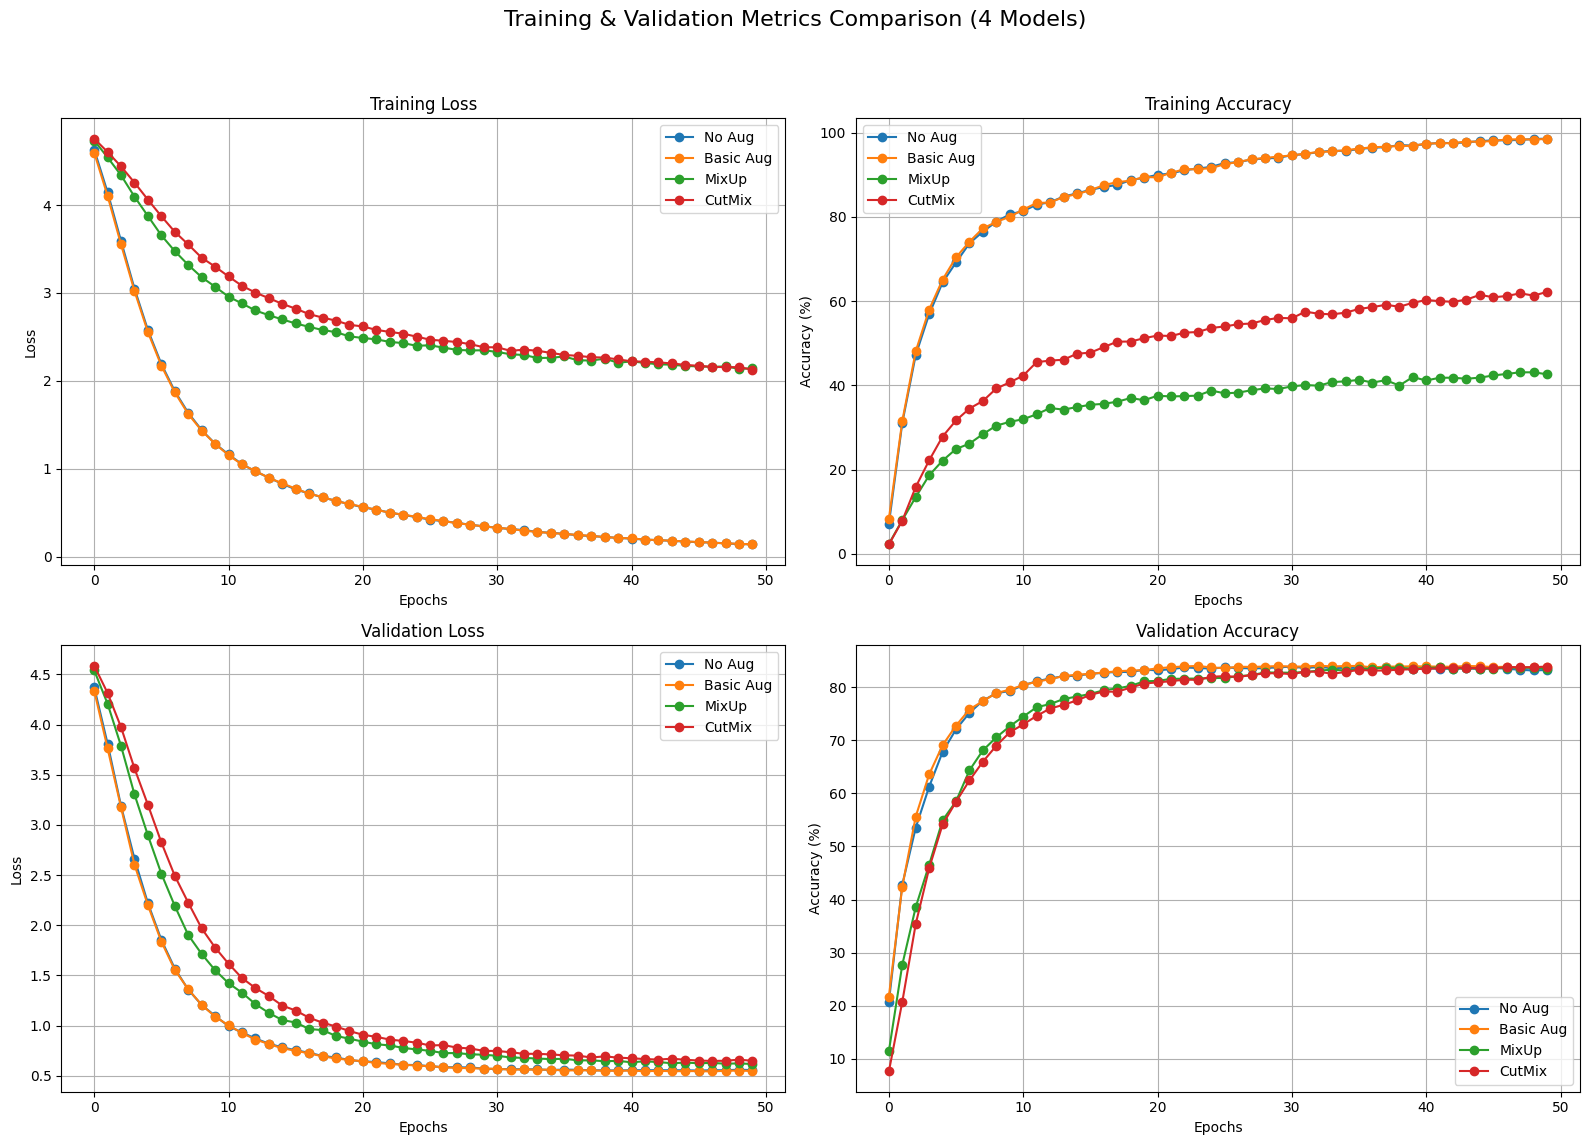

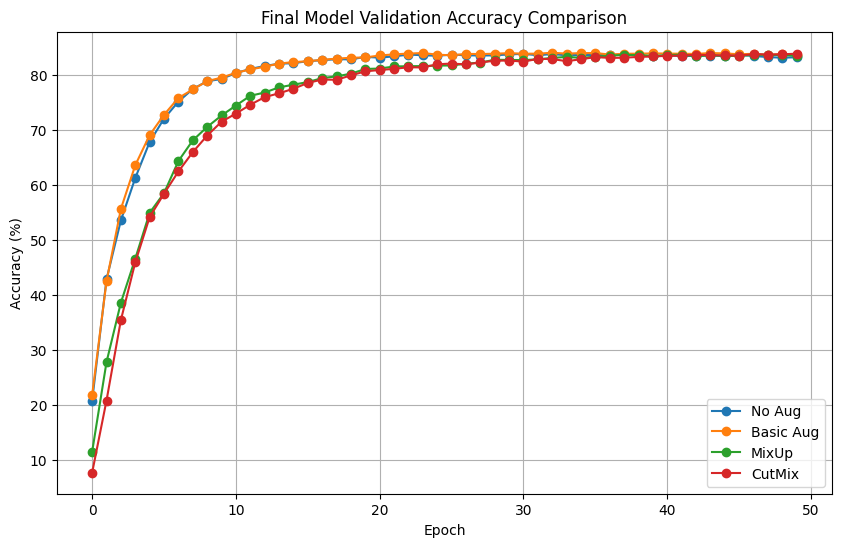


--- Final Validation Accuracy Summary ---
Augmentation | Final Val Acc (%)
--------------------------------------
No Aug       | 83.27%
Basic Aug    | 83.75%
MixUp        | 83.51%
CutMix       | 83.91%


In [11]:
print("\n--- Generating Comparison Plots ---")

# --- 1. 훈련/검증 정확도 및 손실 비교 (4개 플롯) ---
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training & Validation Metrics Comparison (4 Models)', fontsize=16)

# 1. 훈련 손실 (Train Loss)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
for name, history in histories.items():
    ax1.plot(history['train_loss'], label=name, marker='o')
ax1.legend()
ax1.grid(True)

# 2. 훈련 정확도 (Train Accuracy)
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
for name, history in histories.items():
    ax2.plot(history['train_acc'], label=name, marker='o')
ax2.legend()
ax2.grid(True)

# 3. 검증 손실 (Validation Loss)
ax3.set_title('Validation Loss')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
for name, history in histories.items():
    ax3.plot(history['val_loss'], label=name, marker='o')
ax3.legend()
ax3.grid(True)

# 4. 검증 정확도 (Validation Accuracy)
ax4.set_title('Validation Accuracy')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Accuracy (%)')
for name, history in histories.items():
    ax4.plot(history['val_acc'], label=name, marker='o')
ax4.legend()
ax4.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 2. 최종 검증 정확도 비교 (원본 코드 방식) ---
plt.figure(figsize=(10, 6))
plt.title('Final Model Validation Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')

for name, history in histories.items():
    plt.plot(history['val_acc'], label=name, marker='o')

# y축 범위 설정 (원본 코드의 0.5~0.8을 따름)
# plt.ylim(0.50, 0.80)
plt.legend(loc='best')
plt.grid(True)
plt.show()

# --- 3. 최종 결과 요약 (표) ---
print("\n--- Final Validation Accuracy Summary ---")
print("Augmentation | Final Val Acc (%)")
print("--------------------------------------")
for name, history in histories.items():
    print(f"{name:12s} | {history['val_acc'][-1]:.2f}%")

결론
- 실험을 진행한 결과 최종적으로 전부 비슷한 검증 결과가 나왔다. 초반에는 기본 augmentation과 No augmentation인 경우에 성능 향상 속도가 더빨랐다.
Mixup과 cutmix의 경우에 비교적 성능 향상 속도가 느린것을 볼수있었다. epochs가 증가함에 따라 Mixup, Cutmix의 성능도 꾸준히 증가하였고 기본 augmentation의 성능을 따라잡을수있었다.
하지만 train 과정의 loss와 accuracy를 확인해보면 Mixup과 cutmix의 경우 아직 학습이 진행중이고 좀더 진행되면 성능 향상이 충분히 보이는 상황이다. 
추후 learning rate와 epochs를 추가 수정하여 꾸준히 학습해본다면 mixup과 cutmix의 경우가 더 성능이 좋아질 것으로 보인다.

- training과 validation의 성능을 비교해보면 mixup과 cutmix의 경우 오히려 training보다 validation에서 성능이 잘나오는 경우를 확인할 수 있었다. 
이 경우는 training data가 규제가 많이 걸려있거나 학습하기 어려운 data로 구성되어있고 validation의 경우 너무 쉬운 data로 구성되어 있어서 발견된 상황 같다.

추가 실험
1. **LR = 0.01로 변경(기존 : 0.001), Epochs = 20으로 변경(기존 : 50)**
![실험결과1](.image1.png)

- 실험 결과 LR가 너무 높아서 그런지 validation의 결과가 제대로 수렴하지 않은것 같다. 추가로 LR을 조정해서 실험을 진행해 봐야할것같다.

2. **LR = 0.003로 변경(기존 : 0.001), Epochs = 20으로 변경(기존 : 50)**
![실험결과2](.image2.png)

- 실험 결과 기존 실험의 결과와 비슷한 양상을 볼 수 있었다. 적은 epochs로 좀더 먼 결과를 보기 위해 LR을 다시 수정해서 진행해 봐야할것같다.

3. **LR = 0.005로 변경(기존 : 0.001), Epochs = 20으로 변경(기존 : 50)**
![실험결과3](.image3.png)

- 실험 결과 어느정도 값이 수렴하는 것으로 보이인다. 하지만 훈련 과정에서 loss 값이 지속적으로 떨어지는 것을 확인할 수 있었으면 이또한 LR의 값을 수정해서 추가 실험을 진행해봐야할것같다.